# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [2]:
class CTKNet_CNN(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_CNN, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [20, 10, 5]
        conv_kernel = [3, 5, 10]
        pool_kernel = [1, 2, 2]
        fc_unit = [128, 64]
        drop_out = [0.5, 0.5]
        
        # Hidden layers
        img_size = np.array(input_shape[1:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        # self.bn1 = nn.BatchNorm2d(conv_channel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        # self.bn2 = nn.BatchNorm2d(conv_channel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        self.conv3 = nn.Conv2d(in_channels = conv_channel[1], out_channels = conv_channel[2], kernel_size = conv_kernel[2])
        # self.bn3 = nn.BatchNorm2d(conv_channel[2])
        self.pool3 = nn.MaxPool2d(kernel_size = pool_kernel[2])
        img_size = np.floor((img_size - conv_kernel[2] + 1.0) / pool_kernel[2])
        
        fc_input_size = int(np.prod(img_size) * conv_channel[2])
        
        self.fc1 = nn.Linear(in_features = fc_input_size, out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = fc_unit[1])
        self.drop2 = nn.Dropout(drop_out[1])
        
        self.fc3 = nn.Linear(in_features = fc_unit[1], out_features = out_size[0])

        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        # x = self.bn3(x)
        x = self.pool3(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.drop2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x


In [3]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet_CNN(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [4]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [5]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [6]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = True # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [24, 25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = None # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = N_inputtime # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [7]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (14, 129, 170)
Single output data size: (4,)


In [8]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
summary(model, DataSize[0])


CTKNet_CNN(
  (conv1): Conv2d(14, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4680, out_features=128, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 20, 127, 168]           2,540
         MaxPool2d-2         [-1, 20, 127, 168]               0
            Conv2d-3  

/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



1/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09260757118463517 0.09307495815058549 0.10727248722243876
Train/Val/TEST Accuracy: 53.6231884057971 44.44444444444444 14.285714285714286
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.0709953136742115 0.08756681208291815 0.10633717069313639
Train/Val/TEST Accuracy: 57.971014492753625 33.333333333333336 14.285714285714286
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.0498946487903595 0.08151074628242189 0.09134240827656218
Train/Val/TEST Accuracy: 63.768115942028984 61.111111111111114 47.61904761904762
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.036962585896253584 0.0758594115678635 0.0770651192093889
Train/Val/TEST Accuracy: 72.46376811594203 55.55555555555556 57.142857142857146
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.031053361296653748 0.06376582068494624 0.07787214790005237
Train/Val/TEST Accuracy: 68.1159420289855 61.111111111111114 57.142857142857146
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.027691514045000077 0.07151599386189547 0.08415833435

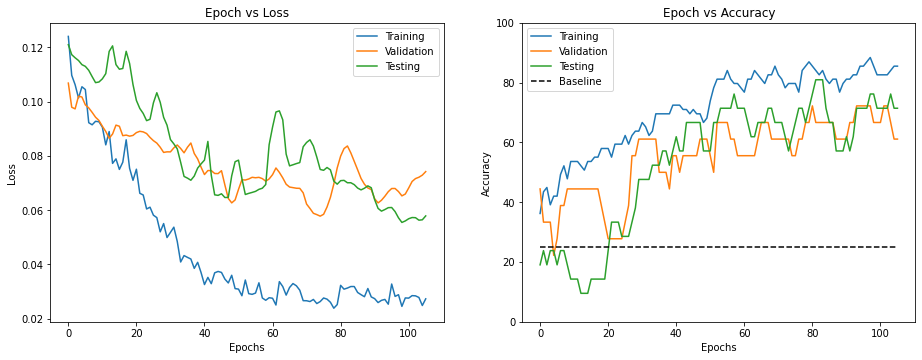

Train/Val/Test Final MSE: [0.0262731209397316, 0.057786337733786136, 0.0750121416169263]
Train/Val/Test Maximum Accuracy: [79.71014492753623, 55.55555555555556, 61.904761904761905]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09000866785645485 0.10228710331850582 0.13536900964876017
Train/Val/TEST Accuracy: 46.3768115942029 33.333333333333336 9.523809523809524
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.07526645734906197 0.10022756291760339 0.12643189703868257
Train/Val/TEST Accuracy: 53.6231884057971 33.333333333333336 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.06262236759066582 0.10648840583033031 0.10475858549276988
Train/Val/TEST Accuracy: 68.1159420289855 27.77777777777778 33.333333333333336
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.04630350321531296 0.1213942030703442 0.11431858614308849
Train/Val/TEST Accuracy: 72.46376811594203 27.77777777777778 42.857142857142854
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.04469485804438591 0.12255664402619004 0.12339950616088961
Train/Val/TEST Accuracy: 78.26086956521739 38.888888888888886 47.61904761904762
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.03444881439208984 0.12793464668922955 0.132169508098048

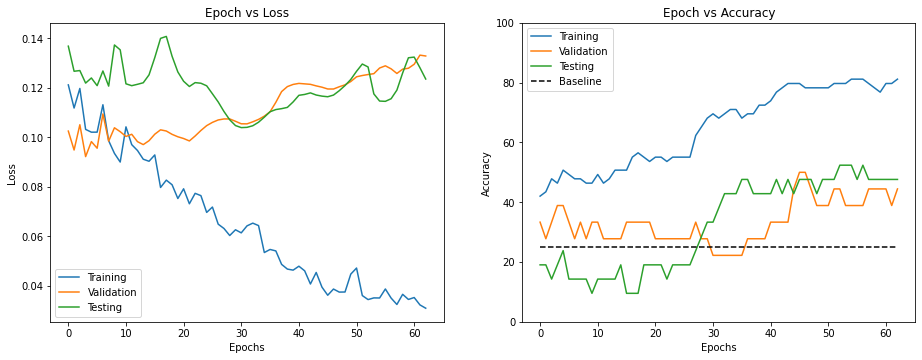

Train/Val/Test Final MSE: [0.06420502290129662, 0.10544817936089304, 0.10403948186320208]
Train/Val/Test Maximum Accuracy: [68.1159420289855, 22.22222222222222, 38.095238095238095]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.0824762649834156 0.11563403318252634 0.13009516302762286
Train/Val/TEST Accuracy: 45.714285714285715 52.94117647058823 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.0686851792037487 0.10224108485614553 0.11670084247764732
Train/Val/TEST Accuracy: 58.57142857142857 64.70588235294117 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.04633486494421959 0.09405898006961626 0.11072918081966539
Train/Val/TEST Accuracy: 68.57142857142857 70.58823529411765 38.095238095238095
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.0333208903670311 0.09053839344586082 0.09936973644376156
Train/Val/TEST Accuracy: 82.85714285714286 64.70588235294117 52.38095238095238
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.03373914323747158 0.08506070730714675 0.11514882911883649
Train/Val/TEST Accuracy: 78.57142857142857 58.8235294117647 42.857142857142854
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.028285977616906165 0.09338055755121305 0.1094748680923311

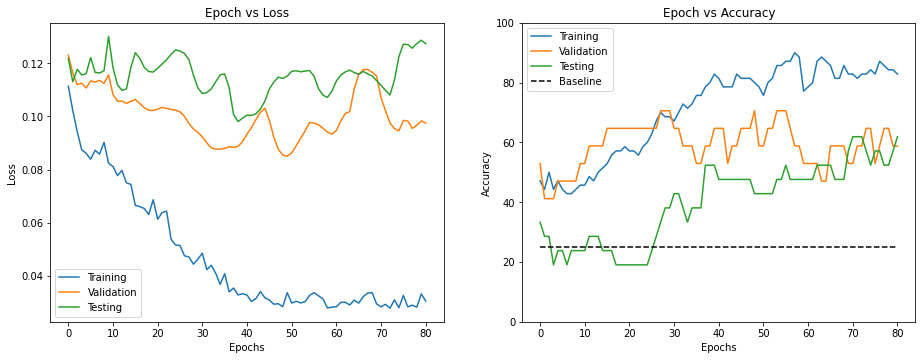

Train/Val/Test Final MSE: [0.03373914323747158, 0.08506070730714675, 0.11514882911883649]
Train/Val/Test Maximum Accuracy: [78.57142857142857, 58.8235294117647, 42.857142857142854]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.0895218387246132 0.11736976673059604 0.11798747225354116
Train/Val/TEST Accuracy: 48.57142857142857 35.294117647058826 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.07393815964460373 0.10554209822679267 0.11267408988039408
Train/Val/TEST Accuracy: 55.714285714285715 41.1764705882353 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.06087215915322304 0.10077622710891507 0.10504070882286344
Train/Val/TEST Accuracy: 67.14285714285714 35.294117647058826 33.333333333333336
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.046583838760852814 0.07647807638653938 0.09057910562980742
Train/Val/TEST Accuracy: 70.0 47.05882352941177 47.61904761904762
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.03523398637771606 0.06364106081138529 0.07864045824057289
Train/Val/TEST Accuracy: 71.42857142857143 52.94117647058823 61.904761904761905
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.03685398958623409 0.06367524433196248 0.08238784979108632
Train/V

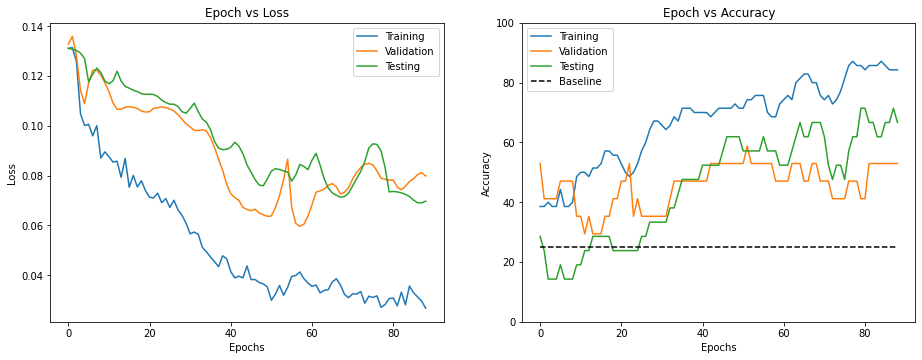

Train/Val/Test Final MSE: [0.04126494824886322, 0.05961953345960116, 0.08446372597522679]
Train/Val/Test Maximum Accuracy: [68.57142857142857, 52.94117647058823, 57.142857142857146]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.09023933559656143 0.12189837972469189 0.12149295627716042
Train/Val/TEST Accuracy: 42.857142857142854 41.1764705882353 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.0845695674419403 0.11499162763357162 0.1255070389071036
Train/Val/TEST Accuracy: 50.0 47.05882352941177 14.285714285714286
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.07054817080497741 0.11413069617222338 0.10699650199551668
Train/Val/TEST Accuracy: 50.0 52.94117647058823 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.04771321564912796 0.11619087412734241 0.10242337693593331
Train/Val/TEST Accuracy: 68.57142857142857 41.1764705882353 42.857142857142854
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.03786250241100788 0.12483185978935045 0.09927270471096217
Train/Val/TEST Accuracy: 71.42857142857143 47.05882352941177 52.38095238095238
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.03175024129450321 0.11093038495849161 0.09950587459440742
Train/Val/TEST Accuracy:

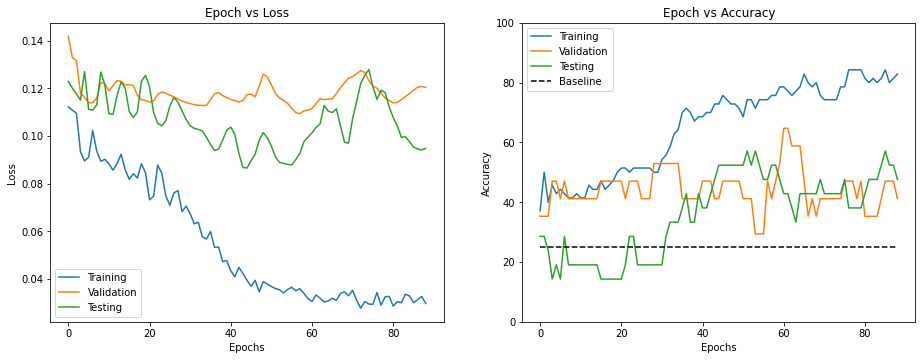

Train/Val/Test Final MSE: [0.03585856184363365, 0.1094188924659701, 0.09262683449889578]
Train/Val/Test Maximum Accuracy: [75.71428571428571, 41.1764705882353, 52.38095238095238]


In [9]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [10]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.04026815943419933, 0.08346673006547943, 0.09425820261461748]
Train/Val/Test Average Accuracy: [74.13664596273291, 46.1437908496732, 50.476190476190474]


## Single prediction results

In [11]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', flabels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.05224169 0.3198323  0.23967366 0.12020524] with label  [1]
Target Example: [0.         1.         0.11111111 0.        ] with label  [1]
------- MSE: 0.12408372759819031  Accuracy: 100.0 %-------

Batch 2  ( Size 1 ):
Output Example: [7.7504140e-01 3.7465646e-04 7.0546871e-01 2.2934936e-01] with label  [0]
Target Example: [1. 0. 1. 0.] with label  [0, 2]
------- MSE: 0.04748908057808876  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.45527384 0.3485508  0.5098564  0.4461882 ] with label  [2]
Target Example: [0.7777778  0.         0.22222222 0.        ] with label  [0]
------- MSE: 0.12682846188545227  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.33268717 0.02130915 0.6614854  0.31890848] with label  [2]
Target Example: [0.         0.         0.44444445 0.7777778 ] with label  [3]
------- MSE: 0.09220065921545029  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.0339632  0.91746706 0.16948406 0.

## 2D emotion plot

In [12]:
# Plot 2D emotions in a plane for all dataset
if Is_2D_to_quardrant_emotion:
    fold = 0 # select the model trained in the corresponding fold
    TwoD_emotion_plotting(args, models_K[fold], FullDataset, LabelRange, subject = 27, game = 4, plot_disk = True)
